# Simple dynamic seq2seq with TensorFlow
Guorui Shen, guorui233@outlook.com

Tutorial for beginer to start building a seq2seq model. Modified from https://github.com/ematvey/tensorflow-seq2seq-tutorials

**Task description**. Given a input, which is a list of integer numbers, say $a = [3, 7, 2]$, the encoder decoder seq2seq model is trained to remember and return the list.

In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [3]:
PAD = 0
EOS = 1

### Model inputs and outputs 

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')   # (8, 100)
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets') # (9, 100)
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')   # (9, 100)

In [5]:
embeddings = tf.Variable(tf.random_uniform([10, 20], -1.0, 1.0), dtype=tf.float32)# (10, 20)

In [6]:
# (10, 8, 20)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

# (10, 9, 20)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)
print encoder_inputs_embedded

Tensor("embedding_lookup:0", shape=(?, ?, 20), dtype=float32)


In [7]:
# # deletable
# encoder_in = [[5, 5, 4, 0, 0, 0, 0, 0], [3, 5, 3, 9, 3, 8, 9, 0]]
# print(sess.run(embeddings).shape)
# print(sess.run(tf.nn.embedding_lookup(embeddings, encoder_in)).shape)
# print(sess.run(tf.nn.embedding_lookup(embeddings, encoder_in))[:, :, :5])

### Encoder

In [8]:
encoder_cell = tf.contrib.rnn.LSTMCell(20)

# 'encoder_final_state' is a tensor of shape [batch_size, num_hidden]
# 'encoder_outputs' is a tensor of shape [batch_size, max_unrolling_time, num_hidden]
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,# (100, 8, 20), max_unrolling_time=8, num_hidden=20
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

### Decoder

In [9]:
decoder_cell = tf.contrib.rnn.LSTMCell(20)

# 'decoder_outputs' is a tensor of shape [batch_size, max_unrolling_time, num_hidden]
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=encoder_final_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [10]:
# 'decoder_logits' is a tensor of shape [batch_size, max_unrolling_time, num_outputs]
decoder_logits = tf.contrib.layers.fully_connected(decoder_outputs, num_outputs=10, activation_fn=None)

# returns the index with the largest value across axes of a tensor.
# 'decoder_prediction' is a tensor of shape [batch_size, max_unrolling_time, 1]
decoder_prediction = tf.argmax(decoder_logits, axis=2)

In [35]:
# deletable
a1, a2 = 6, 5
b1, b2 = tf.one_hot(a1, depth=10), tf.one_hot(a2, depth=10)
print(sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=b1, logits=b2)))

2.4611502


### Optimizer

In [11]:
# 'stepwise_cross_entropy' is a tensor of shape [batch_size, max_unrolling_time, 1]
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=10, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[9 9 0]
 [9 9 4]
 [4 4 4]
 [4 4 4]]


## Generate Data

In [14]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8, # each list has length of at least 3, at most 8
                                   vocab_lower=2, vocab_upper=10, # no less than 2, strictly less than 10
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[2, 2, 2, 2, 2, 2, 3]
[3, 2, 2, 3, 2, 2, 2, 3]
[3, 3, 3, 3, 3, 3, 2, 3]
[3, 2, 2]
[2, 2, 3, 3, 2, 2]
[3, 2, 3, 3, 2, 2, 3, 3]
[3, 2, 3, 3, 2, 3]
[2, 2, 2, 2]
[3, 2, 3, 2, 2]
[3, 3, 3, 2, 2, 3, 2, 3]
[2, 2, 3, 2, 2, 2, 2, 3]
[2, 2, 3, 2, 2, 3, 3, 2]
[3, 2, 2, 3, 2, 2]
[3, 2, 3, 3, 3, 3, 2]
[3, 3, 2, 3, 2, 3, 3]


In [15]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [16]:
data = next_feed()
print(data[encoder_inputs].shape)
print(data[decoder_targets].shape)
for i in range(2):
    print('-----------------------------------------------------------------')
    print('{}th encoder_input  is {}'.format(i, data[encoder_inputs][:, i]))
    print('{}th decoder_input  is {}'.format(i, data[decoder_inputs][:, i]))
    print('{}th decoder_target is {}'.format(i, data[decoder_targets][:, i]))

(8, 100)
(9, 100)
-----------------------------------------------------------------
0th encoder_input  is [3 3 3 0 0 0 0 0]
0th decoder_input  is [1 3 3 3 0 0 0 0 0]
0th decoder_target is [3 3 3 1 0 0 0 0 0]
-----------------------------------------------------------------
1th encoder_input  is [3 3 3 0 0 0 0 0]
1th decoder_input  is [1 3 3 3 0 0 0 0 0]
1th decoder_target is [3 3 3 1 0 0 0 0 0]
-----------------------------------------------------------------
2th encoder_input  is [3 2 3 3 3 2 0 0]
2th decoder_input  is [1 3 2 3 3 3 2 0 0]
2th decoder_target is [3 2 3 3 3 2 1 0 0]


## Train the Model

In [17]:
loss_track = []

In [18]:
for batch in range(3001):
    feeddict = next_feed()
    _, l = sess.run([train_op, loss], feeddict)
    loss_track.append(l)

    if batch == 0 or batch % 1000 == 0:
        print('{}th batch'.format(batch))
        print('  minibatch loss: {}'.format(sess.run(loss, feeddict)))
        predict_ = sess.run(decoder_prediction, feeddict) # feeddict内含decoder_input，为什么可以直接用来预测？？
        for i, (inp, pred) in enumerate(zip(feeddict[encoder_inputs].T, predict_.T)):
            print('  sample {}:'.format(i + 1))
            print('    input     > {}'.format(inp))
            print('    predicted > {}'.format(pred))
            if i >= 1:
                break

0th batch
  minibatch loss: 2.38414382935
  sample 1:
    input     > [3 3 3 3 0 0 0 0]
    predicted > [9 9 2 2 2 4 4 4 4]
  sample 2:
    input     > [2 2 3 2 3 0 0 0]
    predicted > [9 1 1 2 1 2 8 4 4]
1000th batch
  minibatch loss: 0.051749933511
  sample 1:
    input     > [3 2 2 3 3 3 0 0]
    predicted > [3 2 2 3 3 3 1 0 0]
  sample 2:
    input     > [3 3 2 2 2 2 2 0]
    predicted > [3 3 2 2 2 2 2 1 0]
2000th batch
  minibatch loss: 0.0194937121123
  sample 1:
    input     > [2 3 2 2 3 3 3 0]
    predicted > [2 3 2 2 3 3 3 1 0]
  sample 2:
    input     > [2 3 3 3 0 0 0 0]
    predicted > [2 3 3 3 1 0 0 0 0]
3000th batch
  minibatch loss: 0.0073439697735
  sample 1:
    input     > [2 3 2 3 0 0 0 0]
    predicted > [2 3 2 3 1 0 0 0 0]
  sample 2:
    input     > [2 2 2 3 3 2 2 2]
    predicted > [2 2 2 3 3 2 2 2 1]


loss 0.0074 after 300100 examples (batch_size=100)


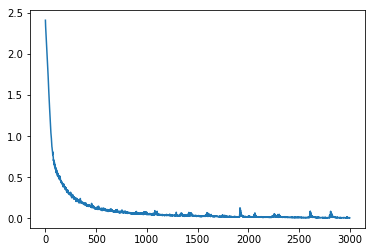

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

# Limitations of the model

We have no control over transitions of `tf.nn.dynamic_rnn`, it is unrolled in a single sweep. Some of the things that are not possible without such control:

- We can't feed previously generated tokens without falling back to Python loops. This means *we cannot make efficient inference with dynamic_rnn decoder*!

- We can't use attention, because attention conditions decoder inputs on its previous state

Solution would be to use `tf.nn.raw_rnn` instead of `tf.nn.dynamic_rnn` for decoder, as we will do in tutorial #2. 

# Fun things to try (aka Exercises)

- In `copy_task` increasing `max_sequence_size` and `vocab_upper`. Observe slower learning and general performance degradation.

- For `decoder_inputs`, instead of shifted target sequence `[<EOS> W X Y Z]`, try feeding `[<EOS> <PAD> <PAD> <PAD>]`, like we've done when we tested forward pass. Does it break things? Or slows learning?

Something is definitely getting learned.